# NMF Practical Work

**Umut Simsekli** 

Telecom Paris

## 1. Factorisation en matrices positives avec la $\beta$-divergence

$$
\begin{aligned}
\left ( {W*}, {H*} \right ) &= argmin_{W \leq 0, H \leq 0} \sum_{i=1}^{I} \sum_{j=1}^J d_{\beta}(x_{ij} || \hat{x}_{ij})
\\
\end{aligned}
$$
$$
\begin{aligned}
S &= \sum_{i=1}^{I} \sum_{j=1}^J d_{\beta}(x_{ij} || \hat{x}_{ij})
\\
&= \sum_{i=1}^{I} \sum_{j=1}^J d_{\beta}(x_{ij} || \hat{x}_{ij})
\\
\frac{\partial d_{\beta}(x_{ij} || \hat{x_{ij}})}{\partial w_{ik}} &= \hat{x}_{ij}^{\beta -1} - x_{ij}\hat{x_{ij}}^{\beta - 2}
\\
\frac{\partial d_{\beta}(x || \hat{x})}{\partial w_{ik}} &= \sum_{J=1}^{J} h_{kj} \left ( \hat{x}_{ij}^{\beta -1} - x_{ij}\hat{x_{ij}}^{\beta  - 2} \right )
\\
&= \left ( \sum_{j=1}^{J} h_{kj} \hat{x}_{ij}^{\beta - 1} \right ) - \left ( \sum_{j=1}^{J} h_{kj} x_{ij} \hat{x}{ij}^{\beta - 2} \right )
&= p_{ik} - m_{ik}
\end{aligned}
$$
Avec $p_{ik}, m_{ik} \geq 0$, on sait mettre à jour $W$ et $H$ de la sorte :
$$
\begin{aligned}
w_{ik} & \leftarrow w_{ik} \frac{m_{ik}}{p_{ik}}
\\
w_{ik} & \leftarrow w_{ik} \frac{\sum_{j=1}^{J} x_{ij}\hat{x_{ij} }^{\beta - 2} h_{kj}}{\sum_{j=1}^{J} \hat{x}_{ij}^{\beta -1} h_{kj}}
\\
h_{kj} & \leftarrow h_{kj} \frac{\sum_{i=1}^{I} x_{ij}\hat{x_{ij} }^{\beta - 2} w_{ik}}{\sum_{i=1}^{I} \hat{x}_{ij}^{\beta -1} w_{ik}}
\end{aligned}
$$

Pour pallier des problèmes numériques quand $W \rightarrow 0$ et $H \rightarrow +\infty$ :
$$
\begin{aligned}
r_k &= ||w_{.k}||
\\
w_{.k} &\leftarrow w_{.k}/r_k
\\
h_{k.} &\leftarrow h_{k.} r_k
\end{aligned}
$$

## 2. Variantes autour d'un exemple simple

### 2. 1 Construction de l'exemple simple

In [8]:
import numpy as np
import numpy.typing as npt
from typing import Callable, Tuple
import os
import scipy.signal as sig

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


<Figure size 432x288 with 0 Axes>

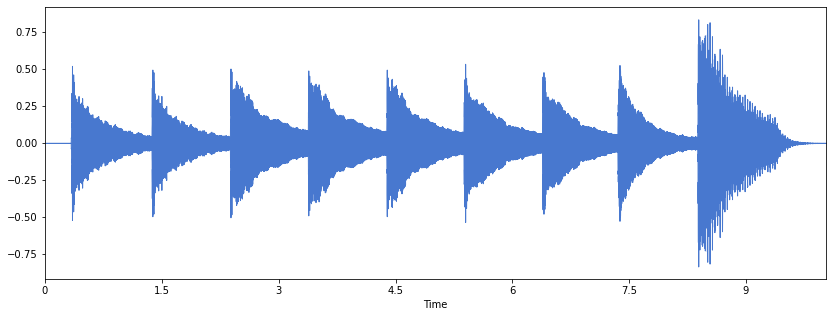

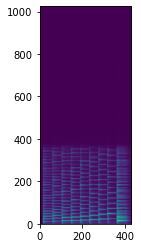

In [2]:
# Audio file
data_path = '../data'
fname = 'Cmajor_piano8khz.wav'
file_path = os.path.join(data_path, fname)

# Load signal
y, sr = librosa.load(file_path)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [ ]:
# Implement MUR for NMF with beta-divergence 



In [ ]:
# Use Wiener filtering to reconstruct each note separately


# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


### 2. 1 Construction de l'exemple simple

On doit choisir la fenêtre de Hann (largueur $\frac{4}{M}$ dans Fourier)
avec une longueur temporelle $M$ telle que l'on ait :
$$
\frac{4}{M} = \frac{80}{f_e}
$$
Soit :
$$
M = \frac{4 f_e}{80}
$$

[ 1.        +0.j          0.97896311+0.20403732j  0.91673754+0.39949002j
  0.81594137+0.57813466j  0.68081545+0.732455j    0.51704506+0.85595818j
  0.33152063+0.94344797j  0.13204787+0.99124334j -0.07298064+0.99733336j
 -0.27493858+0.96146179j -0.46532881+0.8851379j  -0.63614091+0.7715729j
 -0.78018815+0.62554493j -0.89140993+0.45319791j -0.96512672+0.26178314j
 -0.99823699+0.05935417j]
[ 1.        +0.j          0.96667503+0.25600662j  0.86892123+0.49495041j
  0.71325387+0.70090578j  0.51004819+0.86014583j  0.27284783+0.9620572j
  0.01746217+0.99984752j -0.23908734+0.97099807j -0.47970169+0.87743165j
 -0.68834395+0.72538446j -0.85110813+0.52499044j -0.957146  +0.28960583j
 -0.99939015+0.03491902j]
(2, 512)


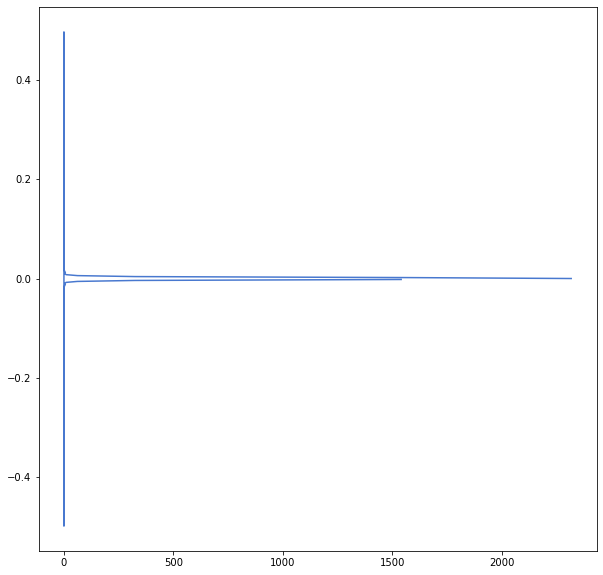

In [43]:
def get_window_harmonic_spectrum(win_fact: Callable[[int], npt.NDArray[float]], f_0s: npt.NDArray[float], f_s: float, n_fft: int) -> npt.NDArray[np.complex128]:
    ks = f_s / f_0s * 0.5
    a_ks = [np.exp(-np.arange(k)/k) for k in ks]
    win_w = 80 / f_s
    m =  int(4 / win_w)
    win = win_fact(m)
    w_rs = [np.empty(n_fft) for _ in np.arange(f_0s.shape[0])]
    for i, a_k in enumerate(a_ks):
        z_shifts = np.exp(2j * np.pi * np.arange(a_k.shape[0]) * f_0s[i] / f_s)
        print(z_shifts)
        win_shifts = np.broadcast_to(win[np.newaxis, ...], shape=a_k.shape + win.shape)
        # Modulate the window by a chosen complex exponential
        # So that each harmonic is add at the appropriate frequency
        win_shifts = z_shifts[..., np.newaxis] * win_shifts
        win_ft = np.fft.fft(win_shifts, n=n_fft, axis=-1)
        w_rs[i] = np.sum(a_k[..., np.newaxis] * win_ft, axis=0)
    w_r = np.zeros((f_0s.shape[0], n_fft), dtype=np.complex128)
    for i in range(len(a_ks)):
        w_r += w_rs[i]
    print(w_r.shape)
    return w_r

f_s = 8000 # Hz
n_fft = 512


f_0s = np.power(2, np.array([-9, -5]) / 12) * 440

w_r = get_window_harmonic_spectrum(sig.windows.hann, f_0s, f_s, n_fft)
freqs = np.fft.fftfreq(n_fft)

plt.figure(figsize=(10, 10))
plt.plot(np.abs(w_r[0]), freqs)
